In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
# Cargar los datos
data_path = 'all_crypto_data.csv'
crypto_data = pd.read_csv(data_path)

In [3]:
# Preparar los datos filtrando los necesarios para el análisis
price_change_data = crypto_data[['symbol', 'price_change_percentage_24h']].dropna()

In [4]:
# Definir umbral de volatilidad
volatility_threshold = price_change_data['price_change_percentage_24h'].quantile(0.5)

# Separar las criptomonedas en dos conjuntos
high_volatility = price_change_data[price_change_data['price_change_percentage_24h'] >= volatility_threshold]
low_volatility = price_change_data[price_change_data['price_change_percentage_24h'] < volatility_threshold]

# Calcular la matriz de correlaciones entre los cambios de precio de las criptomonedas
pivot_prices = price_change_data.pivot(columns='symbol', values='price_change_percentage_24h')
correlation_matrix = pivot_prices.corr()

In [5]:
# Crear el grafo bipartito
B = nx.Graph()

# Agregar los nodos de alta y baja volatilidad
B.add_nodes_from(high_volatility['symbol'], bipartite=0)  # Conjunto A
B.add_nodes_from(low_volatility['symbol'], bipartite=1)  # Conjunto B

# Agregar aristas basadas en correlaciones inversas (negativas) significativas
for symbol_high in high_volatility['symbol']:
    for symbol_low in low_volatility['symbol']:
        if symbol_high in correlation_matrix.columns and symbol_low in correlation_matrix.columns:
            corr = correlation_matrix.at[symbol_high, symbol_low]
            if corr < 0:  
                B.add_edge(symbol_high, symbol_low, weight=corr)

In [6]:
# Mostrar información básica del grafo
print(f"El grafo bipartito tiene {len(B.nodes())} nodos y {len(B.edges())} aristas.")

# Comprobar si el grafo es bipartito
print(f"El grafo es bipartito: {bipartite.is_bipartite(B)}")

El grafo bipartito tiene 5116 nodos y 0 aristas.
El grafo es bipartito: True


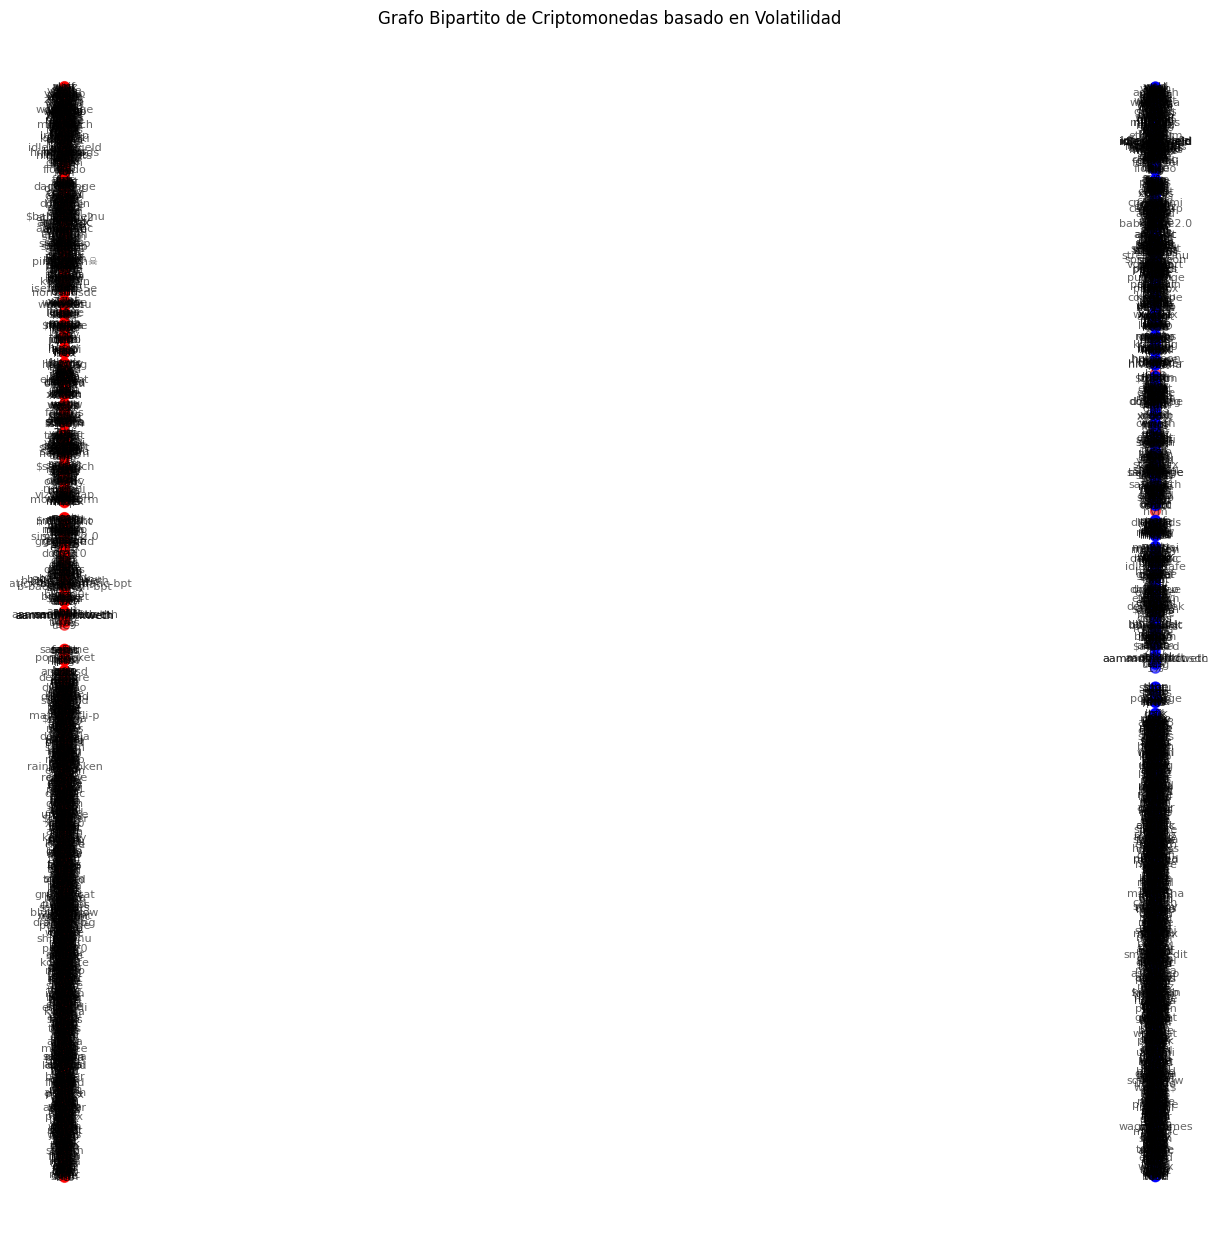

In [7]:
import matplotlib.pyplot as plt

# Dibujar el grafo 
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(high_volatility['symbol']))
pos.update((node, (2, index)) for index, node in enumerate(low_volatility['symbol']))

# Tamaño del grafo para la visualización
plt.figure(figsize=(12, 12))

# Dibujar los nodos y aristas
nx.draw(B, pos, with_labels=True, node_color=['red' if node in high_volatility['symbol'].values else 'blue' for node in B], 
        node_size=50, font_size=8, alpha=0.6, edge_color='gray')

# Mostrar el grafo
plt.title('Grafo Bipartito de Criptomonedas basado en Volatilidad')
plt.show()